### Цель исследования:

Цель данного проекта — выявить, какие признаки имеют наибольшее влияние на цену алмазов. Датафрейм состоит из 10 признаков (7 числовых признаков и 3 категориальных признака).

Анализ данных предполагает последовательное выполнение следующих этапов исследования:<br>
<a href=#1>1.  Предобработка данных</a><br>
<a href=#2>2.  Исследовательский анализ данных</a><br>
<a href=#3>3.  Проведение исследования статистических показателей зависимости цены алмазов от их размеров</a><br>
<a href=#4>4.  Проверка гипотез</a><br>
<a href=#5>5.  Выводы</a><br>

### Столбцы данных
* price - цена<br>
* carat - вес<br>
* cut - качество (Fair, Good, Very Good, Premium, Ideal)<br>
* color - цвет J (худший) to D (лучший)<br>
* clarity - прозрачность (I1 (худшая), SI2, SI1, VS2, VS1, VVS2, VVS1, IF(лучшая))<br>
* x - длина в мм<br>
* y - ширина в мм<br>
* z - глубина в мм<br>
* depth - общий процент глубины
* table - ширина вершины ромба относительно самого широкого места


#  <a name="1">1.Предобработка данных</a>

Подготовка данных к анализу (очистка данных, трансформация данных, дополнение, оптимизация).

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm


import scipy.stats as st
# импорт библиотеки warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузка данных

In [2]:
df = pd.read_csv('diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    52284 non-null  float64
 7   x        32058 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.1+ MB


Количество значений в столбцах различается. Это говорит о том, что в данных есть пустые значения. С помощью библиотеки Seaborn построим тепловую карту для визуализации данных.

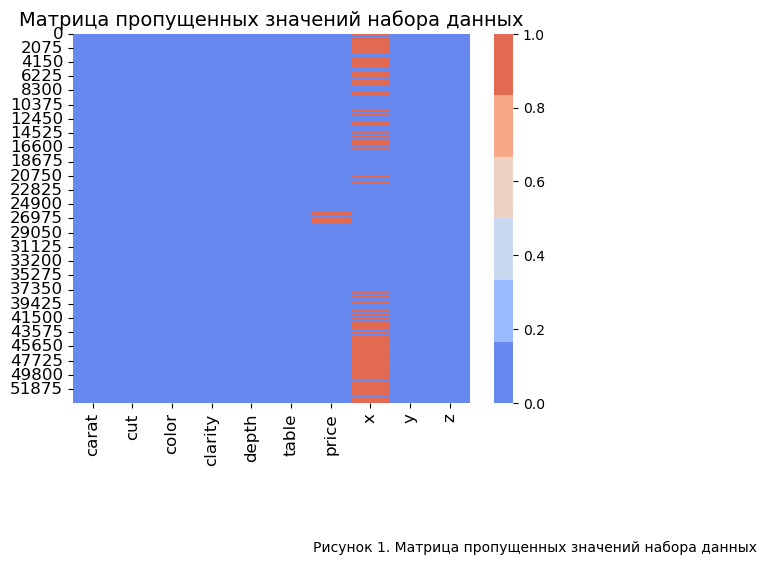

In [4]:
sns.heatmap(df.isnull(), cmap=sns.color_palette('coolwarm'))
plt.title('Матрица пропущенных значений набора данных', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.figtext(0.5, -0.2, "Рисунок 1. Матрица пропущенных значений набора данных")
plt.show()

Количество и процентное соотношение пропущенных значений в каждой переменной в виде таблицы:

In [5]:
no = pd.DataFrame(data = df.isnull().sum(), columns = ['sum_null'])
no['percent'] = round(no.sum_null / df.carat.count() * 100, 1)
no

,sum_null,percent
carat,0,0.0
cut,0,0.0
color,0,0.0
clarity,0,0.0
depth,0,0.0
table,0,0.0
price,1656,3.1
x,21882,40.6
y,0,0.0
z,0,0.0


Так как мы изучаем влияние остальных признаков на цену, то я считаю недопустимым заполнять чем-либо отсутствующие 3,1% значений в столбце price, чтобы не исказить результаты анализа. Удалим эти значения из нашей выборки.

In [6]:
df = df.dropna(axis='index', how='any', subset=['price'])

Теперь разберёмся, могут ли быть заменены чем-либо отсутствующие значения в столбце x (длина в мм).<br>
Известно, что в среднем длина составляет примерно 1,5 - 2 ширины алмаза. То есть приблизительная формула для расчёта длины может выглядеть так:<br>
<center>x = k*y,</center><br>
где х - длина алмаза,<br>
у - ширина алмаза,<br>
k - коэффициент.<br>
Введём новый столбец, в котором рассчитаем значение коэффициента для имеющихся у нас размеров алмазов.

In [7]:
df['k'] = round(df.x / df.y, 2)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,k
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43,0.99
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31,1.01
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31,1.00
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63,0.99
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75,1.00


In [8]:
# Посчитаем средний коэффициент по разным группам алмазов.
ratio = df.groupby('cut').k.mean().to_dict()
ratio

{'Fair': 1.011275167785235,
 'Good': 0.9979672578444748,
 'Ideal': 0.9981005201958384,
 'Premium': 1.0050373355458102,
 'Very Good': 0.994474287585981}

Видим, что средние коэффициенты примерно одинаковые для алмазов разного качества.<br> 
Поэтому просто возьмём средний коэффициент по датасету и, подставив его в формулу выше, заменим пропущенные значения длины алмазов. 

In [9]:
r = df.k.mean()
print(f'Средний коэффициент соотношениея длины и ширины алмаза по датасету равен: {r}.')
df['x'] = df.x.fillna(round(df.y * r,2))
print('Пропущенных значений осталось:')
df.isnull().sum()

Средний коэффициент соотношениея длины и ширины алмаза по датасету равен: 0.9995455442288721.
Пропущенных значений осталось:


carat          0
cut            0
color          0
clarity        0
depth          0
table          0
price          0
x              0
y              0
z              0
k          21874
dtype: int64

Столбец коэффициентов нам больше не нужен, удалим его.

In [10]:
df = df.drop(columns = 'k')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52284 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    52284 non-null  float64
 1   cut      52284 non-null  object 
 2   color    52284 non-null  object 
 3   clarity  52284 non-null  object 
 4   depth    52284 non-null  float64
 5   table    52284 non-null  float64
 6   price    52284 non-null  float64
 7   x        52284 non-null  float64
 8   y        52284 non-null  float64
 9   z        52284 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.4+ MB


Удалим из датасета дубликаты, если они имеются.

In [11]:
df = df.drop_duplicates().reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52142 entries, 0 to 52141
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    52142 non-null  float64
 1   cut      52142 non-null  object 
 2   color    52142 non-null  object 
 3   clarity  52142 non-null  object 
 4   depth    52142 non-null  float64
 5   table    52142 non-null  float64
 6   price    52142 non-null  float64
 7   x        52142 non-null  float64
 8   y        52142 non-null  float64
 9   z        52142 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.0+ MB


Датасет прошёл предварительную обработку. Можно приступать к анализу данных.

#  <a name="2"> 2. Исследовательский анализ данных</a>

* Сгруппировать данные по качеству алмазов и посчитать:<br>
	a. количество алмазов<br>
	b. среднюю цену<br>
	c. максимальный и минимальный карат<br>
	
* На основе этого сформулировать выводы:<br>
	a. Алмазов какого качества больше всего в данных<br>
	b. Какая разница между средними ценами на алмазы качества ideal и premium<br>
	
* Построить сводную таблицу по цвету и качеству, посчитав средний вес алмазов

* Отфильтровать алмазы с качеством good. Найти их среднее значение высоты, ширины и глубины

In [12]:
# Группируем данные по качеству алмазов и находим количество, среднюю цену, максимальный и минимальный карат.
pivot = pd.pivot_table(data = df, index = 'cut', values = 'price', aggfunc = ['count', 'mean'])
pivot_ = pd.pivot_table(data = df, index = 'cut', values = 'carat', aggfunc = ['min', 'max'])
pivot = pd.merge(pivot, pivot_, on = 'cut')
pivot[( 'mean', 'price')] = round(pivot[( 'mean', 'price')] , 1)
print('Сводная таблица, сгруппированная по качеству алмазов:')
pivot

Сводная таблица, сгруппированная по качеству алмазов:


,count,mean,min,max
,price,price,carat,carat
cut,,,,
Fair,1558,4026.1,0.22,3.65
Good,4763,3576.8,0.23,3.00
Ideal,20955,3124.8,0.20,3.50
Premium,13163,4042.5,0.20,3.24
Very Good,11703,3580.8,0.20,3.00


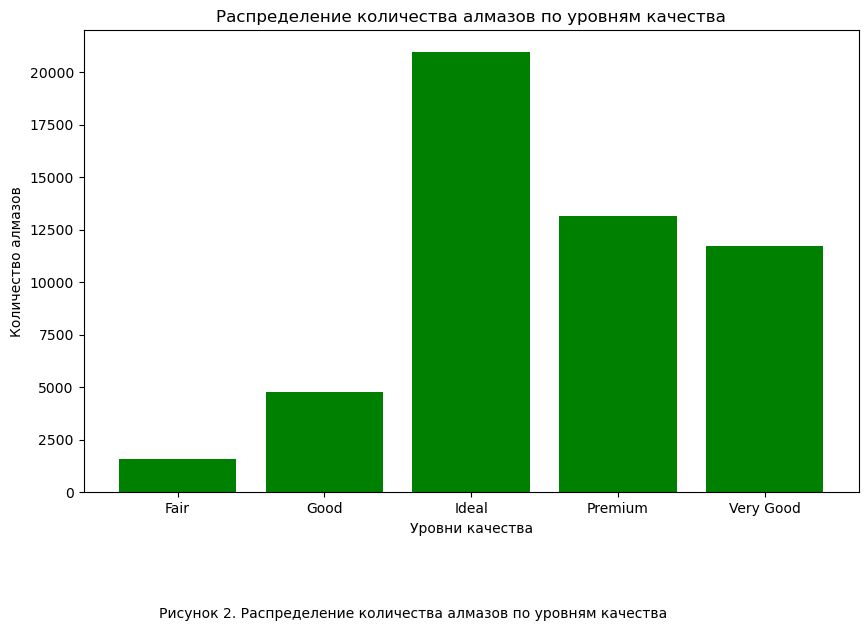

In [13]:
# Построим график, чтобы узнать, алмазов какого качества больше.
plt.figure(figsize = (10, 6))
x = pivot.index
y = pivot[('count', 'price')]
plt.bar(x, y, color = 'green')
plt.title('Распределение количества алмазов по уровням качества')
plt.figtext(0.2, -0.1, "Рисунок 2. Распределение количества алмазов по уровням качества")
plt.xlabel('Уровни качества')
plt.ylabel('Количество алмазов')
plt.show()

In [14]:
# Посчистаем в циврах, алмазов какого уровня качества больше.
print('В данных больше всего алмазов качества:')
df.groupby(by = 'cut').carat.count().nlargest(1).to_dict()

В данных больше всего алмазов качества:


{'Ideal': 20955}

In [15]:
# Найдём разницу в цене алмазов.
y = pivot[('mean', 'price')].to_dict()
res = round(y.get('Premium') - y.get('Ideal'), 1)
print(f'Разница в цене между алмазами качества Premium и Ideal составляет: {res}')

Разница в цене между алмазами качества Premium и Ideal составляет: 917.7


In [16]:
# Построим сводную таблицу со средним весом алмазов в зависимости от цвета и качества.
carat = pd.pivot_table(data = df, index = ['color', 'cut'], values = 'carat', aggfunc = 'mean')
carat['carat'] = round(carat['carat'], 2)
print('Сводная таблица со средним весом алмазов определённого цвета и качества:')
carat

Сводная таблица со средним весом алмазов определённого цвета и качества:


carat
color cut             
D     Fair        0.87
      Good        0.73
      Ideal       0.56
      Premium     0.70
      Very Good   0.68
E     Fair        0.84
      Good        0.72
      Ideal       0.57
      Premium     0.69
      Very Good   0.66
F     Fair        0.88
      Good        0.75
      Ideal       0.63
      Premium     0.80
      Very Good   0.71
G     Fair        1.00
      Good        0.82
      Ideal       0.67
      Premium     0.80
      Very Good   0.74
H     Fair        1.18
      Good        0.87
      Ideal       0.76
      Premium     0.96
      Very Good   0.87
I     Fair        1.14
      Good        0.98
      Ideal       0.85
      Premium     1.04
      Very Good   0.96
J     Fair        1.26
      Good        1.08
      Ideal       0.99
      Premium     1.22
      Very Good   1.11

Построим столбчатую диаграмму для большей наглядности.

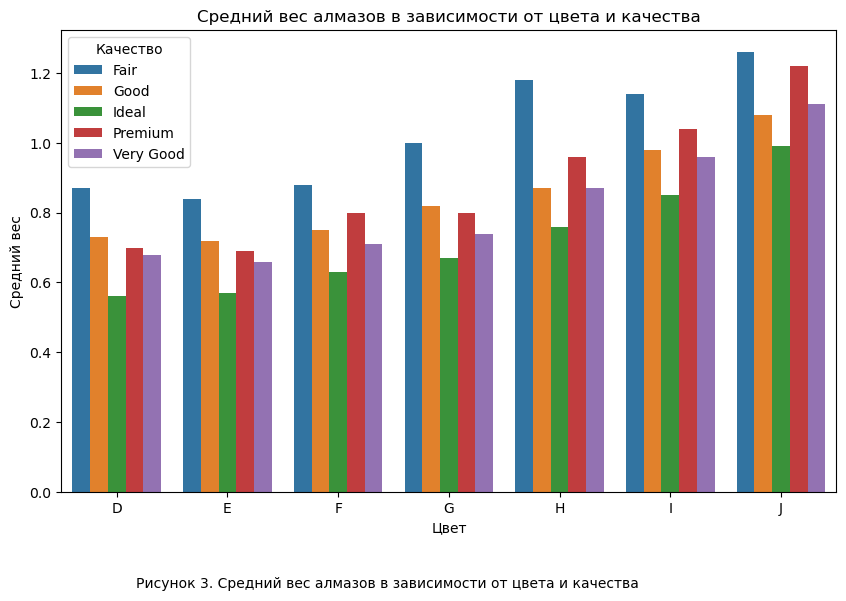

In [17]:
# Сброс индекса и преобразование данных в формат long.
carat_ = carat.reset_index()

# Построение графика.
plt.figure(figsize = (10,6))
sns.barplot(data = carat, x = 'color', y = 'carat', hue = 'cut')
plt.title('Средний вес алмазов в зависимости от цвета и качества')
plt.xlabel('Цвет')
plt.ylabel('Средний вес')
plt.legend(title = 'Качество')
plt.figtext(0.2, -0.05, "Рисунок 3. Средний вес алмазов в зависимости от цвета и качества")
plt.show()

In [18]:
# Отфильтруем данные - создадим отдельный датафрейм для алмазов с качеством Good.
good = df[df.cut == 'Good'].reset_index(drop = True)
good = good.drop(columns = 'cut')
good.head()

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
1,0.31,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
2,0.30,J,SI1,64.0,55.0,339.0,4.25,4.28,2.73
3,0.30,J,SI1,63.4,54.0,351.0,4.23,4.29,2.70
4,0.30,J,SI1,63.8,56.0,351.0,4.23,4.26,2.71


In [19]:
# Найдём средние значения высоты, ширины и глубины.
print('Средние значения параметров алмазов качества Good:')
print(f'Высота - {round(good.x.mean(), 2)} мм')
print(f'Ширина - {round(good.y.mean(), 2)} мм')
print(f'Глубина - {round(good.z.mean(), 2)} мм')

Средние значения параметров алмазов качества Good:
Высота - 5.79 мм
Ширина - 5.79 мм
Глубина - 3.6 мм


#  <a name="3">3. Проведение исследования статистических показателей зависимости цены алмазов от их размеров</a>

In [20]:
# Посмотрим описательную статистику по датасету.
df.describe()

,carat,depth,table,price,x,y,z
count,52142.000000,52142.000000,52142.000000,52142.000000,52142.000000,52142.000000,52142.000000
mean,0.760571,61.752509,57.440294,3527.036055,5.661889,5.662986,3.495066
std,0.426619,1.426948,2.233065,3314.583149,1.062993,1.079963,0.666998
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.390000,61.100000,56.000000,932.000000,4.690000,4.700000,2.900000
50%,0.700000,61.800000,57.000000,2307.000000,5.670000,5.670000,3.500000
75%,1.020000,62.500000,59.000000,5000.000000,6.500000,6.480000,4.010000
max,3.650000,79.000000,95.000000,14998.000000,31.790000,58.900000,31.800000


In [21]:
# Построим матрицу корреляций.
cor = df[['price', 'carat', 'depth', 'x', 'y', 'z', 'table']]
matrix = cor.corr()
matrix

,price,carat,depth,x,y,z,table
price,1.000000,0.918691,-0.000575,0.885734,0.868680,0.867482,0.125427
carat,0.918691,1.000000,0.038695,0.971902,0.951367,0.956248,0.181562
depth,-0.000575,0.038695,1.000000,-0.020874,-0.023151,0.106459,-0.294721
x,0.885734,0.971902,-0.020874,1.000000,0.977283,0.964441,0.188242
y,0.868680,0.951367,-0.023151,0.977283,1.000000,0.947448,0.180644
z,0.867482,0.956248,0.106459,0.964441,0.947448,1.000000,0.146775
table,0.125427,0.181562,-0.294721,0.188242,0.180644,0.146775,1.000000


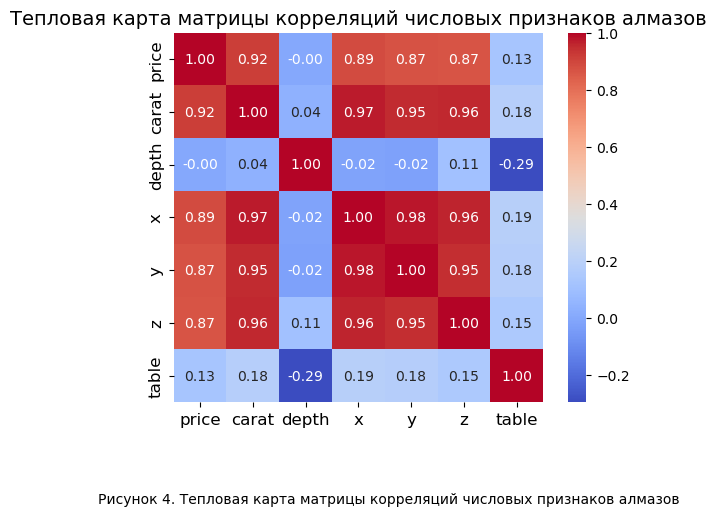

In [28]:
# Для наглядности построим тепловую карту матрицы корреляций.
sns.heatmap(matrix, annot = True, square = True, cmap='coolwarm', fmt = '.2f')
plt.title('Тепловая карта матрицы корреляций числовых признаков алмазов', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.figtext(0.05, -0.1, "Рисунок 4. Тепловая карта матрицы корреляций числовых признаков алмазов")
plt.show()

На тепловой карте видно, что цена коррелирует с весом алмазов и их размером. А вес, в свою очередь, также имеет значительную корреляцию с габаритами алмаза. Далее имеет смысл рассматривать только корреляцию цены с весом, так как её корреляция с размерами алмазов автоматически вытекает из зависимости веса алмаза от его размера.

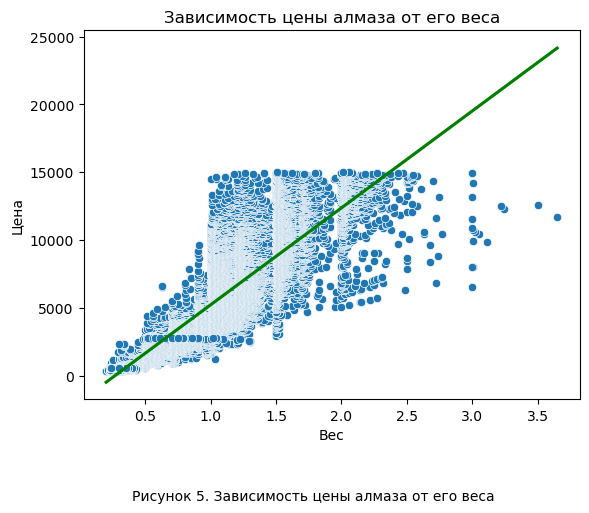

In [30]:
# Построим диаграмму рассеяния.
sns.scatterplot(y = 'price', x = 'carat', data = df)
sns.regplot(y = 'price', x = 'carat', data = df, scatter = False, color = 'green')
plt.xlabel('Вес')
plt.ylabel('Цена')
plt.title('Зависимость цены алмаза от его веса')
plt.figtext (0.2, -0.1, 'Рисунок 5. Зависимость цены алмаза от его веса')
plt.show()

In [24]:
# Построим линейную регрессию, чтобы полнее изучить зависимость цены от веса алмаза.
import statsmodels.api as sm
X = df['carat']
y = df['price']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 2.821e+05
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:10:59   Log-Likelihood:            -4.4822e+05
No. Observations:               52142   AIC:                         8.964e+05
Df Residuals:                   52140   BIC:                         8.965e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1901.6891     11.720   -162.265      0.000   -1924.660   -1878.718
carat       7137.6938     13.439    531.109      0.000    7111.353    7164.035
==============================================================================
Omnibus:                    13496.765   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.093
Skew:                           1.005   Prob(JB):                         0.00
Kurtosis:                      10.010   Cond. No.                         3.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-квадрат равен 0.844, это очень сильная зависимость. Цена на алмаз на 84.4% определяется его весом. Чтобы полнее исследовать факторы, определяющие стоимость алмазов, можно рассмотреть нечисловые признаки датасета.

#  <a name="4">4. Проверка гипотез </a>

Выясним, влияет ли цвет на стоимость алмаза.<br>

Н0: Цвет не влияет на стоимость алмаза.<br>
Н1: Цвет влияет на стомость алмаза.

In [25]:
# Сгруппируем данные стоимости по цвету алмазов и проведём тест ANOVA.
color = df.groupby(by = 'color').price.apply(list)
f_statistic, p_value = st.f_oneway(*color)

# Вывод результатов теста
print("Результаты f-теста:")
print("f-статистика =", f_statistic)
print("p-значение =", p_value)

# Оценка статистической значимости результатов
alpha = 0.05 # Выберем стандартное пороговое значение критерия.
if p_value < alpha:
    print("Отклоняем нулевую гипотезу, цвет влияет на стоимость алмаза.")
else:
    print("Не отклоняем нулевую гипотезу, цвет не влияет на стоимость алмаза.")

Результаты f-теста:
f-статистика = 245.48838061700351
p-значение = 1.00544541571114e-310
Отклоняем нулевую гипотезу, цвет влияет на стоимость алмаза.


Проверием ещё один категориальный параметр.<br>

Н0: Прозрачность не влияет на стоимость алмаза.<br>
Н1: Прозрачность влияет на стоимость алмаза.<br>

In [26]:
# Сгруппируем данные стоимости по прозрачности алмазов и проведём тест ANOVA.
clarity = df.groupby(by = 'clarity').price.apply(list)
f_statistic, p_value = st.f_oneway(*clarity)

# Вывод результатов теста
print("Результаты f-теста:")
print("f-статистика =", f_statistic)
print("p-значение =", p_value)

# Оценка статистической значимости результатов
alpha = 0.05 # Выберем стандартное пороговое значение критерия.
if p_value < alpha:
    print("Отклоняем нулевую гипотезу, прозрачность влияет на стоимость алмаза.")
else:
    print("Не отклоняем нулевую гипотезу, прозрачность не влияет на стоимость алмаза.")

Результаты f-теста:
f-статистика = 190.06144066148502
p-значение = 1.7206267502752348e-279
Отклоняем нулевую гипотезу, прозрачность влияет на стоимость алмаза.


Проверим последний категориальный параметр.<br>

Н0: Качество не влияет на цену алмаза.<br>
Н1: Качество влияет на цену алмаза.<br>

In [27]:
# Сгруппируем данные стоимости по цвету алмазов и проведём тест ANOVA.
cut = df.groupby(by = 'cut').price.apply(list)
f_statistic, p_value = st.f_oneway(*cut)

# Вывод результатов теста
print("Результаты f-теста:")
print("f-статистика =", f_statistic)
print("p-значение =", p_value)

# Оценка статистической значимости результатов
alpha = 0.05 # Выберем стандартное пороговое значение критерия.
if p_value < alpha:
    print("Отклоняем нулевую гипотезу, качество влияет на стоимость алмаза.")
else:
    print("Не отклоняем нулевую гипотезу, качество не влияет на стоимость алмаза.")

Результаты f-теста:
f-статистика = 168.72403132014077
p-значение = 8.175546218672835e-144
Отклоняем нулевую гипотезу, качество влияет на стоимость алмаза.


В результате проверки гипотез было установлено, что помимо веса на стоимость алмаза также влияют качество огранки, цвет и прозрачность.

#  <a name="5">5. Выводы</a>

* В датасете представлено больше алмазов качества Ideal.
* Разница в цене между алмазами качества Premium и Ideal составляет: 917.7
* Максимальный вес алмаза в датасете 3.65 карата, а минимальный - 0,2 карата.
* Чем лучше цвет и качество обработки алмаза, тем меньше его вес.
* Средний вес алмаза в датасете 0,76 карата, а средняя цена - 3527,04.
* На стоимость алмазов влияют 4 параметра: вес, цвет, прозрачность и качество обработки. Причём вес определяет цену алмазов на 84.4%.